In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False ## 마이너스 부호 깨짐 방지

pd.set_option('display.max_columns', None)                       # 출력할 열의 최대개수
pd.set_option('display.max_colwidth', None)                      # 출력할 열의 너비
# pd.reset_option('display.max_rows', None)                    # 출력할 행의 최대개수  None
pd.set_option('display.unicode.east_asian_width', True) 

## sessions
사용자에 대한 웹 세션 로그
- user_id: to be joined with the column 'id' in users table
- action -> 조회, 검색결과, 대시보드 등 다양한 액션이 있음 -> click에 대한 대분류이지 않을까?
- action_type
- action_detail
- device_type -> 웹 방문에 대한 기기 종류
- secs_elapsed -> 세션에 머문 시간 (초단위)

세션 데이터세트에서 데이터는 2014년 1월 1일까지만 거슬러 올라가는 반면, 사용자 데이터세트는 2010년까지 거슬러 올라갑니다.

In [2]:
## sessions
sessions = pd.read_csv('D:\데브코스_최종프로젝트/airbnb-recruiting-new-user-bookings/sessions.csv')
sessions.head()

,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,319.0
1,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,67753.0
2,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,301.0
3,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,22141.0
4,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,435.0


In [3]:
sessions.isnull().sum()

user_id            34496
action             79626
action_type      1126204
action_detail    1126204
device_type            0
secs_elapsed      136031
dtype: int64

## user_id
- 결측치 - 34496 존재 -> train 데이터와 id로 결합하기 어려움으로 삭제하는 것이 좋아보임

In [4]:
## user_id 결측치 삭제
sessions.dropna(subset=['user_id'], inplace=True)

In [5]:
sessions.isnull().sum()

user_id                0
action             79480
action_type      1122957
action_detail    1122957
device_type            0
secs_elapsed      135483
dtype: int64

## action_detail 대분류 진행 -> Action? 

In [6]:
## 원본 데이터 보존
new_sessions = sessions.copy()

## Nan값 0으로 변환
new_sessions = new_sessions.fillna(0)

In [7]:
def list_diff(a, b):
    set_a = set(a)
    set_b = set(b)
    a_ = list(set_a - set_b)
    b_ = list(set_b - set_a)
    total_ = a_ + b_
    # print(f'a에만 있고 b에는 없는 것{set_a - set_b}')
    # print(f'b에만 있고 a에는 없는 것{set_b - set_a}')
    print(total_)
    return True

# 비교 함수
def find_diff(list1, list2):
    for i in list1:
        if i not in list2:
            print(i)

In [8]:
# ##################################### 검색/조회
# view_search = ['view_locations', 'view_search_results', 'p3', 'unavailable_dates', 'p5', 'p4', 'p1', 'popular_wishlists', 
#                'terms_and_privacy', 'click_about_host', 'move_map', 'click_amenities', 'toggle_archived_thread', 
#                'user_friend_recommendations', 'p4_refund_policy_terms', 'translations', 'p4_terms', 'toggle_starred_thread',
#               'cancellation_policy', 'share', 'view_security_checks', 'place_worth', 'view_resolutions', 
#                'view_user_real_names', 'view_ghostings', 'view_ghosting_reasons', 'homepage',
#               'special_offer_field', 'tos_2014', 'your_trips', 'notifications', 'photos','profile_references', 'cancellation_policies'] 
# # unavailable_dates -> 여행 특성 변경으로 고려


# ##################################### 미정
# unknown = ['-unknown-',]

# ##################################### 위시리스트
# wishlist = ['wishlist', 'wishlist_content_update', 'user_wishlists', 'wishlist_note', 'friends_wishlists', 'email_wishlist_button',
#            'email_wishlist', 'airbnb_picks_wishlists']

# ##################################### 정보 수정
# user_update = ['user_profile', 'header_userpic', 'edit_profile', 'user_profile_content_update', 'phone_verification_success',
#               'account_transaction_history', 'account_privacy_settings', 'user_languages', 'delete_phone_numbers',
#               'change_or_alter', 'account_payment_methods', 'modify_users', 'previous_trips', 'at_checkpoint',
#                'alteration_field', 'change_password', 'create_payment_instrument', 'view_identity_verifications',
#               'phone_numbers', 'set_default_payment_instrument', 'deactivate_user_account',
#               'delete_payment_instrument', 'update_user', 'create_phone_numbers', 'update_user_profile', 
#              'account_notification_settings', 'request_new_confirm_email', 'account_payout_preferences', 'profile_verifications']

# ##################################### 여행 특성 변경
# change_trip = ['change_trip_characteristics', 'trip_availability']

# ##################################### 로그인/로그아웃
# login_out = ['user_social_connections', 'login', 'oauth_response', 'oauth_login', 'login_page', 'login_modal', 'forgot_password', 'set_password', 
#              'set_password_page', 'confirm_email']

# ##################################### 리뷰조회
# review = ['user_reviews', 'profile_reviews', 'click_reviews']

# ##################################### 호스트 관련
# host = ['similar_listings', 'listing_reviews', 'update_listing', 'dashboard', 'user_listings', 'your_listings', 'listing_recommendations', 'update_listing_description',
#        'manage_listing', 'view_listing', 'list_your_space', 'create_listing', 'listing_descriptions', 'listing_reviews_page',
#         'translate_listing_reviews', 'delete_listing_description', 'delete_listing', 'calculate_worth', 'change_availability',
#        'host_respond', 'admin_templates', 'host_guarantee', 'user_tax_forms', 'host_home', 'respond_to_alteration_request', 
#         'host_standard_suspension', 'host_respond_page', 'remove_dashboard_alert', 'post_checkout_action']

# ##################################### 예약관련
# booking = ['instant_book', 'coupon_code_click', 'change_contact_host_dates', 'reservations', 'payment_instruments',
#            'pending', 'apply_coupon', 'book_it', 'apply_coupon_click', 'request_to_book',
#           'your_reservations','guest_receipt', 'guest_itinerary', 'complete_booking', 'booking', 'guest_cancellation', 
#            'apply_coupon_click_success', 'modify_reservations', 'view_reservations', 'alteration_request', 'create_alteration_request', 
#            'host_refund_guest', 'cancellation_policy_click','apply_coupon_error', 'coupon_field_focus']
# # 'guest_cancellation'(취소), 'modify_reservations'(애매), 'cancellation_policy_click'(취소) 'host_refund_guest' -> 환불이기 때문에 추후 분석해보기?

# ##################################### 회원가입
# new_user = ['confirm_email_link', 'create_user', 'signup', 'signup_login_page', 'signup_modal', 'read_policy_click']

# ##################################### 메시지
# message = ['contact_host', 'message_thread', 'message_post', 'message_inbox', 'send_message','message_to_host_focus', 'lookup_message_thread', 'message_to_host_change']

In [9]:
# new_list = view_search + unknown + user_update + change_trip + login_out + review + host + booking + new_user + message + wishlist
# new_sessions['action_detail'].replace(view_search, 'view_search', inplace=True)

### 검색/조회

In [10]:
# unavailable_dates -> 여행 특성 변경으로 고려
view_search = ['view_locations', 'view_search_results', 'p3', 'unavailable_dates', 'p5', 'p4', 'p1', 'popular_wishlists', 
               'terms_and_privacy', 'click_about_host', 'move_map', 'click_amenities', 'toggle_archived_thread', 
               'user_friend_recommendations', 'p4_refund_policy_terms', 'translations', 'p4_terms', 'toggle_starred_thread',
              'cancellation_policy', 'share', 'view_security_checks', 'place_worth', 'view_resolutions', 
               'view_user_real_names', 'view_ghostings', 'view_ghosting_reasons', 'homepage',
              'special_offer_field', 'tos_2014', 'your_trips', 'notifications', 'photos','profile_references', 'cancellation_policies'] 


In [11]:
new_sessions['action_detail'].replace(view_search, 'view_search', inplace=True)

### Unknown

In [12]:
unknown = ['-unknown-',]

In [13]:
new_sessions['action_detail'].replace(unknown, 'unknown', inplace=True)

### 위시리스트

In [14]:
wishlist = ['wishlist', 'wishlist_content_update', 'user_wishlists', 'wishlist_note', 'friends_wishlists', 'email_wishlist_button',
           'email_wishlist', 'airbnb_picks_wishlists']

In [15]:
new_sessions['action_detail'].replace(wishlist, 'wishlist', inplace=True)

### 정보 수정

In [16]:
user_update = ['user_profile', 'header_userpic', 'edit_profile', 'user_profile_content_update', 'phone_verification_success',
              'account_transaction_history', 'account_privacy_settings', 'user_languages', 'delete_phone_numbers',
              'change_or_alter', 'account_payment_methods', 'modify_users', 'previous_trips', 'at_checkpoint',
               'alteration_field', 'change_password', 'create_payment_instrument', 'view_identity_verifications',
              'phone_numbers', 'set_default_payment_instrument', 'deactivate_user_account',
              'delete_payment_instrument', 'update_user', 'create_phone_numbers', 'update_user_profile', 
             'account_notification_settings', 'request_new_confirm_email', 'account_payout_preferences', 'profile_verifications']

In [17]:
new_sessions['action_detail'].replace(user_update, 'user_update', inplace=True)

### 여행 특성 변경

In [18]:
change_trip = ['change_trip_characteristics', 'trip_availability']

In [19]:
new_sessions['action_detail'].replace(change_trip, 'change_trip', inplace=True)

### 로그인/로그아웃
- 'oauth_response', -> 네이버 등  간편 로그인 기능도 OAuth2 프로토콜 기반의 사용자 인증 기능을 제공



In [20]:
login_out = ['user_social_connections', 'login', 'oauth_response', 'oauth_login', 'login_page', 'login_modal', 'forgot_password', 'set_password', 
             'set_password_page', 'confirm_email']

In [21]:
new_sessions['action_detail'].replace(login_out, 'login_out', inplace=True)

### 리뷰 조회

In [22]:
review = ['user_reviews', 'profile_reviews', 'click_reviews']

In [23]:
new_sessions['action_detail'].replace(review, 'review', inplace=True)

### 호스트

In [24]:
host = ['similar_listings', 'listing_reviews', 'update_listing', 'dashboard', 'user_listings', 'your_listings', 'listing_recommendations', 'update_listing_description',
       'manage_listing', 'view_listing', 'list_your_space', 'create_listing', 'listing_descriptions', 'listing_reviews_page',
        'translate_listing_reviews', 'delete_listing_description', 'delete_listing', 'calculate_worth', 'change_availability',
       'host_respond', 'admin_templates', 'host_guarantee', 'user_tax_forms', 'host_home', 'respond_to_alteration_request', 
        'host_standard_suspension', 'host_respond_page', 'remove_dashboard_alert', 'post_checkout_action']

In [25]:
new_sessions['action_detail'].replace(host, 'host', inplace=True)

### 예약
- 예약 보류, 예약 취소

In [26]:
booking = ['instant_book', 'coupon_code_click', 'change_contact_host_dates', 'reservations', 'payment_instruments',
           'pending', 'apply_coupon', 'book_it', 'apply_coupon_click', 'request_to_book',
          'your_reservations','guest_receipt', 'guest_itinerary', 'complete_booking', 'booking', 'guest_cancellation', 
           'apply_coupon_click_success', 'modify_reservations', 'view_reservations', 'alteration_request', 'create_alteration_request', 
           'host_refund_guest', 'cancellation_policy_click','apply_coupon_error', 'coupon_field_focus']

# 'guest_cancellation'(취소), 'modify_reservations'(애매), 'cancellation_policy_click'(취소) 'host_refund_guest' -> 환불이기 때문에 추후 분석해보기?

In [27]:
new_sessions['action_detail'].replace(booking, 'booking', inplace=True)

### 회원가입

In [28]:
new_user = ['confirm_email_link', 'create_user', 'signup', 'signup_login_page', 'signup_modal', 'read_policy_click']

In [29]:
new_sessions['action_detail'].replace(new_user, 'new_user', inplace=True)

### 메시지

In [30]:
message = ['contact_host', 'message_thread', 'message_post', 'message_inbox', 'send_message','message_to_host_focus', 'lookup_message_thread', 'message_to_host_change']

In [31]:
new_sessions['action_detail'].replace(message, 'message', inplace=True)

## 분류 확인

In [32]:
# orginlist = new_sessions['action_detail'].unique().tolist()
# new_list = view_search + unknown + user_update + change_trip + login_out + review + host + booking + new_user + message + wishlist
# new_df = pd.DataFrame(new_list)
# print(new_df[new_df.duplicated()])

# EDA -> 분류 진행 후

In [33]:
def object_fq_view(column):
    #빈도 계산
    counts = new_sessions[column].value_counts(normalize=True)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x=counts.index, y=counts.values, palette='viridis') 
    plt.title(f'{column}')
    plt.xlabel(f'{column}')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

In [ ]:
## 명목형 빈도 계산 후 그래프 그리기
# view_columns = new_sessions.columns[2:5].tolist()

# for column in view_columns:
#     object_fq_view(column)

In [ ]:
# sns.boxplot(y=new_sessions['secs_elapsed'])
# plt.title('Seconds Elapsed')
# plt.xlabel('secs_elapsed')
# plt.show()

## action 종류 확인

In [ ]:
# len(new_sessions['action'].unique())

In [ ]:
# new_sessions['action'].unique()

In [ ]:
# action = new_sessions['action'].value_counts()
# action.describe()

In [ ]:
# log_action = np.log1p(action)
# log_action.describe()

In [ ]:
# plt.subplots(figsize=(12, 7))

# sns.barplot(y=log_action[log_action.values > 10].index, x=log_action[log_action.values > 10].values)
# plt.xticks(rotation=90)  
# plt.tight_layout()
# plt.title('action 종류')
# plt.show()

In [ ]:
# new_sessions[new_sessions['action'] == 'refinement_paths']

## 파생변수 생성

In [34]:
new_sessions['user_flow'] = new_sessions['action'].astype('str') + '+' + new_sessions['action_type'].astype('str') + '+' + new_sessions['action_detail'].astype('str')

In [35]:
new_sessions

,user_id,action,action_type,action_detail,device_type,secs_elapsed,user_flow
0,d1mm9tcy42,lookup,0,0,Windows Desktop,319.0,lookup+0+0
1,d1mm9tcy42,search_results,click,view_search,Windows Desktop,67753.0,search_results+click+view_search
2,d1mm9tcy42,lookup,0,0,Windows Desktop,301.0,lookup+0+0
3,d1mm9tcy42,search_results,click,view_search,Windows Desktop,22141.0,search_results+click+view_search
4,d1mm9tcy42,lookup,0,0,Windows Desktop,435.0,lookup+0+0
...,...,...,...,...,...,...,...
10567732,9uqfg8txu3,dashboard,view,host,Windows Desktop,556.0,dashboard+view+host
10567733,9uqfg8txu3,edit,view,user_update,Windows Desktop,6624.0,edit+view+user_update
10567734,9uqfg8txu3,webcam_upload,-unknown-,unknown,Windows Desktop,200125.0,webcam_upload+-unknown-+unknown
10567735,9uqfg8txu3,active,-unknown-,unknown,-unknown-,17624.0,active+-unknown-+unknown


### 전체 유저의 first flow

C:\Users\daesk\AppData\Local\Temp\ipykernel_9564\2795706067.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=first_flow.index, y=first_flow.values, palette='viridis')


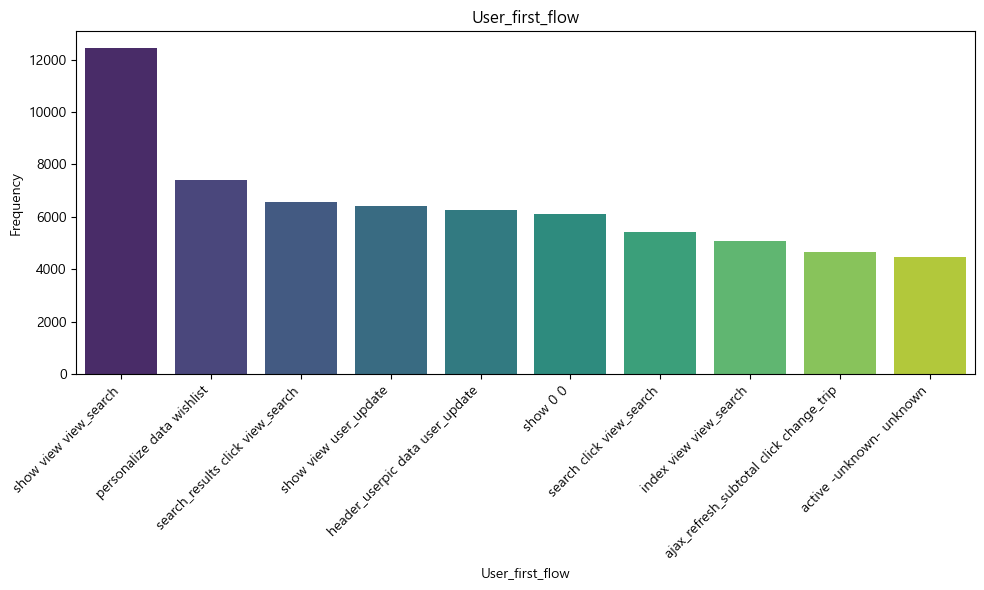

In [151]:
first_flow = new_sessions.groupby('user_id')['user_flow'].first().value_counts()[:10]

plt.figure(figsize=(10, 6))
sns.barplot(x=first_flow.index, y=first_flow.values, palette='viridis') 
plt.title('User_first_flow')
plt.xlabel('User_first_flow')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### 예약자 유저의 first flow

C:\Users\daesk\AppData\Local\Temp\ipykernel_9564\4114715395.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=booking_user_first_flow.index, y=booking_user_first_flow.values, palette='viridis')


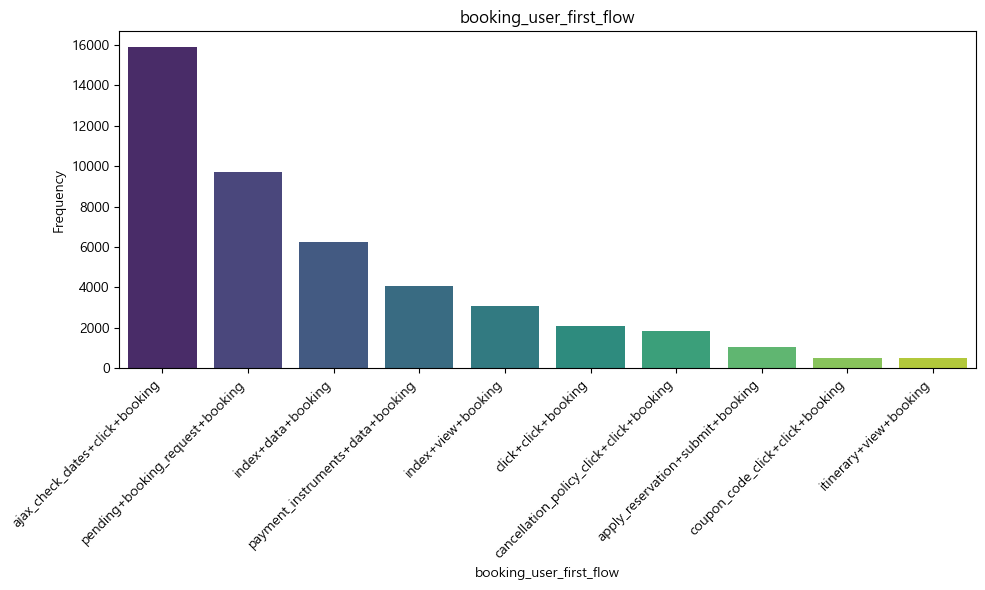

In [154]:
### 'action_detail'이 'booking'인 행만 필터링
booking_user = new_sessions[new_sessions['action_detail'] == 'booking']

## 예약한 사용자에 action_flow 확인
booking_user_first_flow = booking_user.groupby('user_id')['user_flow'].first().value_counts()[:10]

plt.figure(figsize=(10, 6))
sns.barplot(x=booking_user_first_flow.index, y=booking_user_first_flow.values, palette='viridis') 
plt.title('booking_user_first_flow')
plt.xlabel('booking_user_first_flow')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### 비예약자 유저의 first flow

C:\Users\daesk\AppData\Local\Temp\ipykernel_9564\2516112783.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=no_booking_user_first_flow.index, y=no_booking_user_first_flow.values, palette='viridis')


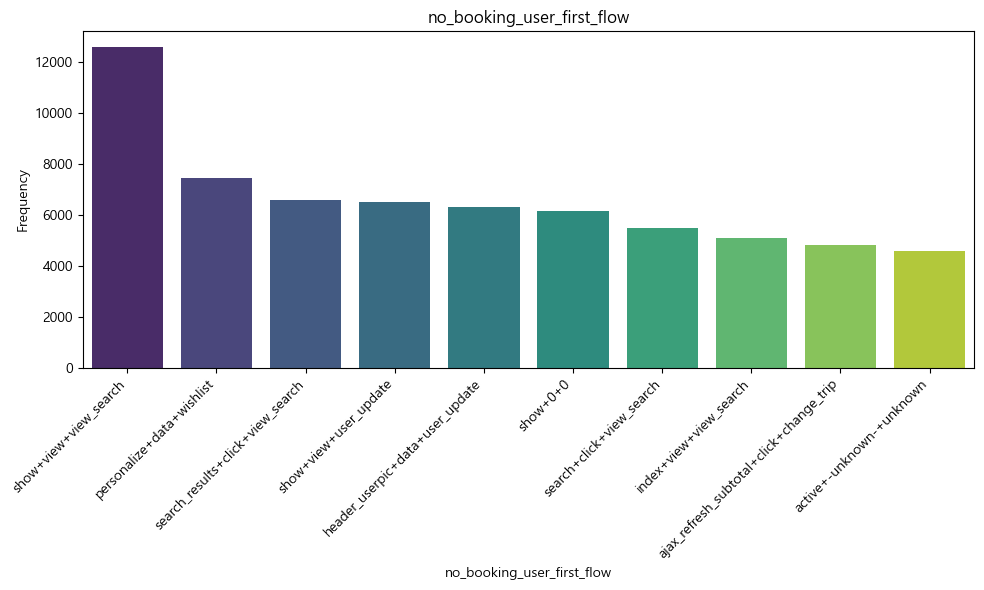

In [158]:
# 'action_detail'이 'booking'하지 않은 행만 필터링
no_booking_user = new_sessions[new_sessions['action_detail'] != 'booking']

## 예약한 사용자에 action_flow 확인
no_booking_user_first_flow = no_booking_user.groupby('user_id')['user_flow'].first().value_counts()[:10]

plt.figure(figsize=(10, 6))
sns.barplot(x=no_booking_user_first_flow.index, y=no_booking_user_first_flow.values, palette='viridis') 
plt.title('no_booking_user_first_flow')
plt.xlabel('no_booking_user_first_flow')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [159]:
# new_sessions.groupby('user_id')['user_flow'].first().value_counts().describe()

### 전체 유저의 last flow

C:\Users\daesk\AppData\Local\Temp\ipykernel_9564\441494736.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=last_flow.index, y=last_flow.values, palette='viridis')


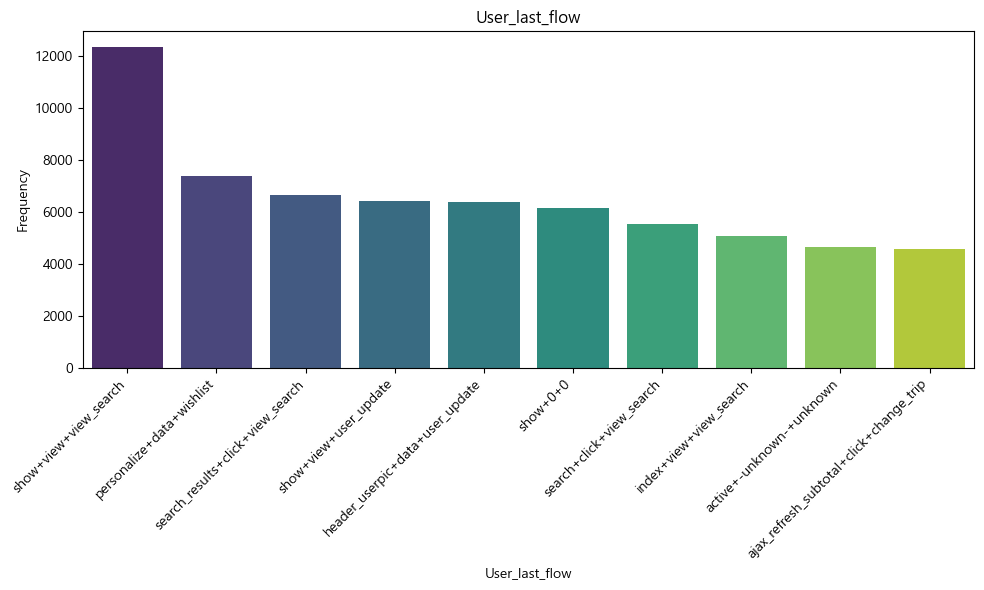

In [163]:
last_flow = new_sessions.groupby('user_id')['user_flow'].last().value_counts()[:10]

plt.figure(figsize=(10, 6))
sns.barplot(x=last_flow.index, y=last_flow.values, palette='viridis') 
plt.title('User_last_flow')
plt.xlabel('User_last_flow')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### 예약자 유저의 last flow

C:\Users\daesk\AppData\Local\Temp\ipykernel_9564\3003897816.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=booking_user_last_flow.index, y=booking_user_last_flow.values, palette='viridis')


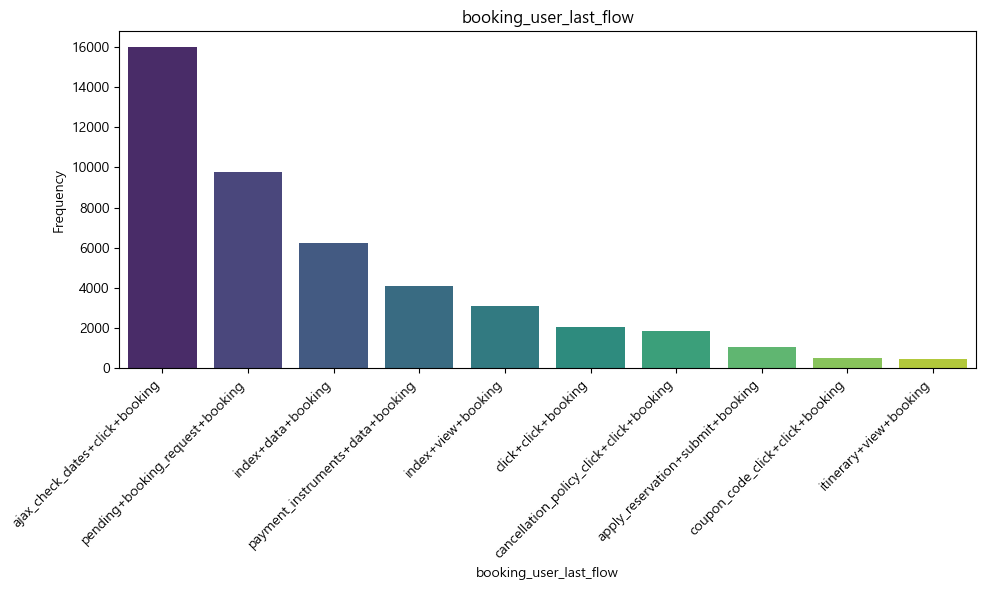

In [164]:
### 'action_detail'이 'booking'인 행만 필터링
booking_user = new_sessions[new_sessions['action_detail'] == 'booking']

## 예약한 사용자에 action_flow 확인
booking_user_last_flow = booking_user.groupby('user_id')['user_flow'].last().value_counts()[:10]

plt.figure(figsize=(10, 6))
sns.barplot(x=booking_user_last_flow.index, y=booking_user_last_flow.values, palette='viridis') 
plt.title('booking_user_last_flow')
plt.xlabel('booking_user_last_flow')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### 비예약자 유저의 last flow

C:\Users\daesk\AppData\Local\Temp\ipykernel_9564\355070868.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=no_booking_user_last_flow.index, y=no_booking_user_last_flow.values, palette='viridis')


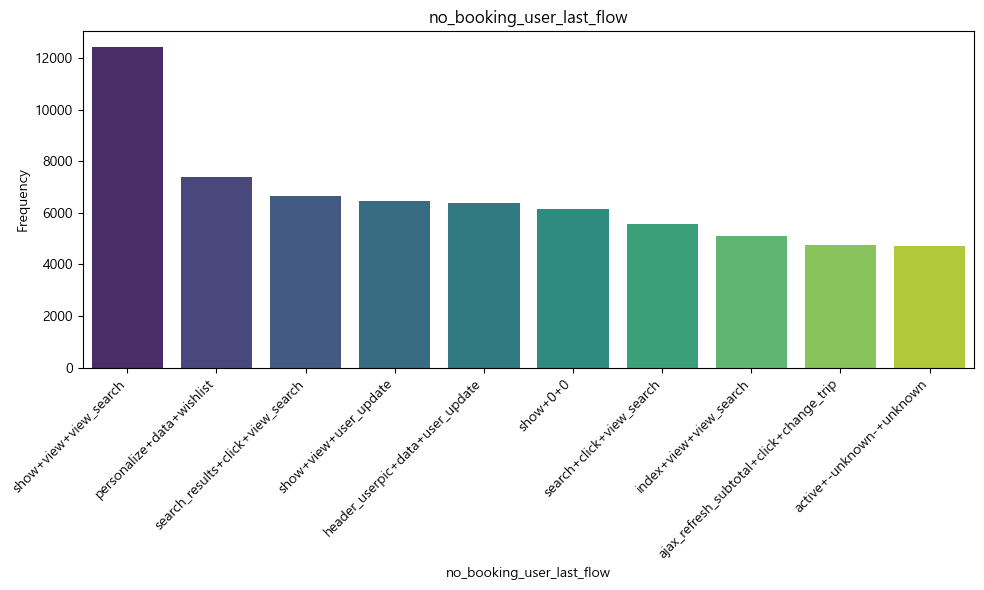

In [160]:
# 'action_detail'이 'booking'하지 않은 행만 필터링
no_booking_user = new_sessions[new_sessions['action_detail'] != 'booking']

## 예약한 사용자에 action_flow 확인
no_booking_user_last_flow = no_booking_user.groupby('user_id')['user_flow'].last().value_counts()[:10]

plt.figure(figsize=(10, 6))
sns.barplot(x=no_booking_user_last_flow.index, y=no_booking_user_last_flow.values, palette='viridis') 
plt.title('no_booking_user_last_flow')
plt.xlabel('no_booking_user_last_flow')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [165]:
# # 'action_detail'이 'booking'인 행만 필터링
# booking_user = new_sessions[new_sessions['action_detail'] == 'booking']

# ## 예약한 사용자에 action_flow 확인
# booking_user_last_flow = booking_user.groupby('user_id')['user_flow'].last().value_counts()[:10]

# plt.figure(figsize=(10, 6))
# sns.barplot(x=booking_user_last_flow.index, y=booking_user_last_flow.values, palette='viridis') 
# plt.title('booking_user_last_flow')
# plt.xlabel('booking_user_last_flow')
# plt.ylabel('Frequency')
# plt.xticks(rotation=45, ha='right')
# plt.tight_layout()
# plt.show()

C:\Users\daesk\AppData\Local\Temp\ipykernel_9564\1943861442.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=last_flow.index, y=last_flow.values, palette='viridis')


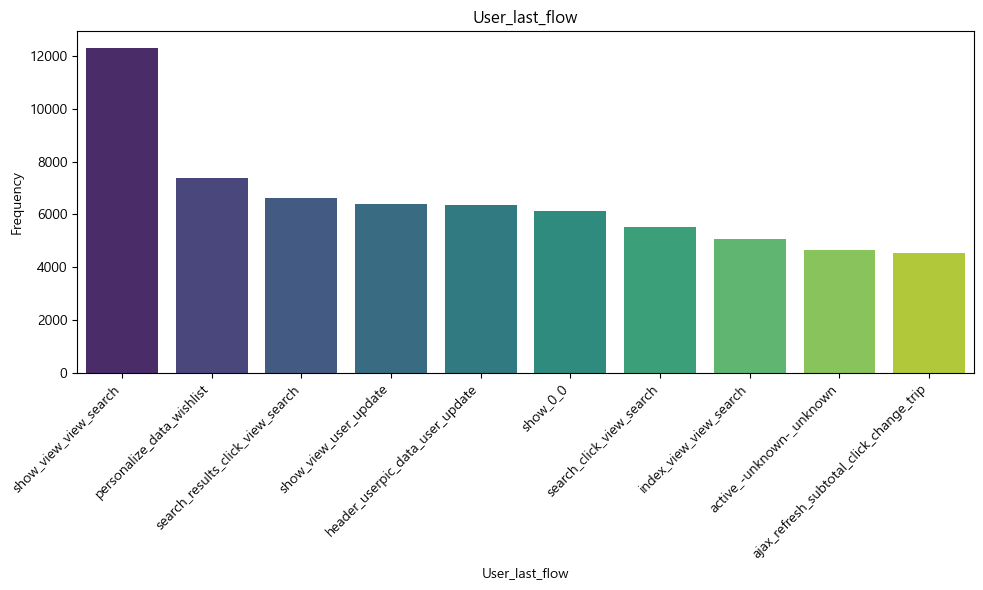

In [ ]:
# 'action_detail'이 'booking'하지 않은 행만 필터링
no_booking_user = new_sessions[new_sessions['action_detail'] != 'booking']

## 예약한 사용자에 action_flow 확인
booking_user_first_flow = no_booking_user.groupby('user_id')['user_flow'].first().value_counts()[:10]

plt.figure(figsize=(10, 6))
sns.barplot(x=booking_user_first_flow.index, y=booking_user_first_flow.values, palette='viridis') 
plt.title('booking_user_first_flow')
plt.xlabel('booking_user_first_flow')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [121]:
new_sessions.groupby('user_id')['user_flow'].last().value_counts().describe()

count      310.000000
mean       437.041935
std       1316.086435
min          1.000000
25%          5.250000
50%         24.500000
75%        173.500000
max      12322.000000
Name: count, dtype: float64

In [114]:
new_sessions.groupby(['user_id', 'user_flow']).size().unstack(fill_value=0)

user_flow,0_message_post_message,10_message_post_message,11_message_post_message,12_message_post_message,15_message_post_message,about_us_-unknown-_unknown,accept_decline_view_host,account_-unknown-_unknown,acculynk_bin_check_failed_-unknown-_unknown,acculynk_bin_check_success_-unknown-_unknown,acculynk_load_pin_pad_-unknown-_unknown,acculynk_pin_pad_error_-unknown-_unknown,acculynk_pin_pad_inactive_-unknown-_unknown,acculynk_pin_pad_success_-unknown-_unknown,acculynk_session_obtained_-unknown-_unknown,active_-unknown-_unknown,add_business_address_colorbox_-unknown-_unknown,add_guest_colorbox_-unknown-_unknown,add_guests_-unknown-_unknown,add_note_submit_wishlist,agree_terms_check_-unknown-_unknown,agree_terms_uncheck_-unknown-_unknown,airbnb_picks_view_wishlist,airbrb_-unknown-_unknown,ajax_check_dates_click_booking,ajax_get_referrals_amt_-unknown-_unknown,ajax_get_results_click_view_search,ajax_google_translate_-unknown-_unknown,ajax_google_translate_description_-unknown-_unknown,ajax_google_translate_reviews_click_host,ajax_image_upload_-unknown-_unknown,ajax_ldp_-unknown-_unknown,ajax_lwlb_contact_click_message,ajax_payout_edit_-unknown-_unknown,ajax_payout_options_by_country_-unknown-_unknown,ajax_payout_split_edit_-unknown-_unknown,ajax_photo_widget_-unknown-_unknown,ajax_photo_widget_form_iframe_-unknown-_unknown,ajax_price_and_availability_click_user_update,ajax_referral_banner_experiment_type_-unknown-_unknown,ajax_referral_banner_type_-unknown-_unknown,ajax_refresh_subtotal_click_change_trip,ajax_send_message_-unknown-_unknown,ajax_special_offer_dates_available_click_view_search,ajax_statsd_-unknown-_unknown,ajax_worth_submit_host,apply_-unknown-_unknown,apply_code_-unknown-_unknown,apply_coupon_click_click_booking,apply_coupon_click_success_click_booking,apply_coupon_error_click_booking,apply_coupon_error_type_-unknown-_unknown,apply_reservation_submit_booking,approve_-unknown-_unknown,approve_submit_host,ask_question_submit_message,at_checkpoint_booking_request_user_update,authenticate_submit_login_out,authenticate_view_login_out,authorize_-unknown-_unknown,available_-unknown-_unknown,available_data_change_trip,badge_-unknown-_unknown,become_user_-unknown-_unknown,book_view_view_search,booking_booking_response_booking,braintree_client_token_0_0,business_travel_-unknown-_unknown,calendar_tab_inner2_-unknown-_unknown,callback_partner_callback_login_out,campaigns_-unknown-_unknown,campaigns_0_0,cancel_submit_booking,cancellation_policies_view_view_search,cancellation_policy_click_click_booking,change_availability_-unknown-_unknown,change_availability_submit_host,change_currency_-unknown-_unknown,change_default_payout_-unknown-_unknown,change_password_submit_user_update,change_view_user_update,check_0_0,city_count_-unknown-_unknown,clear_reservation_-unknown-_unknown,click_-unknown-_unknown,click_click_booking,click_click_message,click_click_review,click_click_view_search,clickthrough_-unknown-_unknown,collections_-unknown-_unknown,collections_view_wishlist,complete_-unknown-_unknown,complete_redirect_-unknown-_unknown,complete_status_-unknown-_unknown,concierge_-unknown-_unknown,confirm_email_-unknown-_unknown,confirm_email_click_login_out,confirm_email_click_new_user,confirmation_-unknown-_unknown,connect_-unknown-_unknown,connect_submit_login_out,contact_new_-unknown-_unknown,countries_-unknown-_unknown,country_options_-unknown-_unknown,coupon_code_click_click_booking,coupon_field_focus_click_booking,create_-unknown-_unknown,create_ach_-unknown-_unknown,create_airbnb_-unknown-_unknown,create_multiple_-unknown-_unknown,create_paypal_-unknown-_unknown,create_submit_booking,create_submit_host,create_submit_new_user,create_submit_user_update,create_view_host,currencies_-unknown-_unknown,currencies_0_0,custom_recommended_destinations_-unknown-_unknown,dashboard_view_host,deactivate_-unknown-_unknown,deactivated_view_host,deauthorize_-unknown-_unknown,decision_tree_-unknown-_unknown,delete_-unknown-_booking,delete_-unknow

In [ ]:
# # 첫 번째 액션 파생변수 생성
# first_action = new_sessions.groupby('user_id')['action'].first()
# session_df = new_sessions.merge(first_action, on='user_id', suffixes=('', '_first'))
# session_df.rename(columns={'action_first': 'first_action'}, inplace=True)

# # 마지막 액션 파생변수 생성
# last_action = new_sessions.groupby('user_id')['action'].last()
# session_df = new_sessions.merge(last_action, on='user_id', suffixes=('', '_last'))
# session_df.rename(columns={'action_last': 'last_action'}, inplace=True)

# # 특정 액션 유형의 발생 횟수 파생변수 생성
# action_count = session_df.groupby(['user_id', 'action_type']).size().unstack(fill_value=0)
# session_df = session_df.merge(action_count, on='user_id')

# # 가장 많이 발생한 액션 유형 파생변수 생성
# most_common_action = session_df.groupby('user_id')['action_type'].apply(lambda x: x.value_counts().idxmax())
# session_df = session_df.merge(most_common_action, on='user_id', suffixes=('', '_most_common'))
# session_df.rename(columns={'action_type_most_common': 'most_common_action'}, inplace=True)

# # 결과 출력
# print(session_df)
# # 총 세션 시간 계산
# total_session_time = new_sessions.groupby('user_id')['secs_elapsed'].sum().reset_index(name='total_secs')

# # 평균 세션 시간 계산
# average_session_time = new_sessions.groupby('user_id')['secs_elapsed'].mean().reset_index(name='avg_secs')

# # 가장 자주 사용된 기능
# most_frequent_action = new_sessions.groupby('user_id')['action'].agg(lambda x:x.value_counts().index[0]).reset_index(name='most_frequent_action')

# # 장치 유형별 사용자 수
# device_type_counts = new_sessions['device_type'].value_counts().reset_index(name='user_count')

In [ ]:
print(total_session_time)
print(average_session_time)
print(most_frequent_action)
print(device_type_counts)

In [ ]:
ㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁ

### Train_Session 병합

In [77]:
## train_users_2
train = pd.read_csv('D:\데브코스_최종프로젝트/airbnb-recruiting-new-user-bookings/train_users_2.csv')
train.rename(columns={'id':'user_id'},inplace=True)

In [78]:
df = pd.merge(new_sessions, train, on='user_id', how='inner')
df

,user_id,action,action_type,action_detail,device_type,secs_elapsed,user_flow,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,d1mm9tcy42,lookup,0,0,Windows Desktop,319.0,lookup+0+0,2014-01-01,20140101000936,2014-01-04,MALE,62.0,basic,0,en,sem-non-brand,google,omg,Web,Windows Desktop,Chrome,other
1,d1mm9tcy42,search_results,click,view_search,Windows Desktop,67753.0,search_results+click+view_search,2014-01-01,20140101000936,2014-01-04,MALE,62.0,basic,0,en,sem-non-brand,google,omg,Web,Windows Desktop,Chrome,other
2,d1mm9tcy42,lookup,0,0,Windows Desktop,301.0,lookup+0+0,2014-01-01,20140101000936,2014-01-04,MALE,62.0,basic,0,en,sem-non-brand,google,omg,Web,Windows Desktop,Chrome,other
3,d1mm9tcy42,search_results,click,view_search,Windows Desktop,22141.0,search_results+click+view_search,2014-01-01,20140101000936,2014-01-04,MALE,62.0,basic,0,en,sem-non-brand,google,omg,Web,Windows Desktop,Chrome,other
4,d1mm9tcy42,lookup,0,0,Windows Desktop,435.0,lookup+0+0,2014-01-01,20140101000936,2014-01-04,MALE,62.0,basic,0,en,sem-non-brand,google,omg,Web,Windows Desktop,Chrome,other
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5537952,nw9fwlyb5f,index,data,booking,iPhone,245.0,index+data+booking,2014-06-30,20140630235824,NaN,-unknown-,NaN,basic,25,en,direct,direct,untracked,iOS,iPhone,-unknown-,NDF
5537953,nw9fwlyb5f,unavailabilities,data,view_search,iPhone,286.0,unavailabilities+data+view_search,2014-06-30,20140630235824,NaN,-unknown-,NaN,basic,25,en,direct,direct,untracked,iOS,iPhone,-unknown-,NDF
5537954,nw9fwlyb5f,notifications,submit,view_search,iPhone,830.0,notifications+submit+view_search,2014-06-30,20140630235824,NaN,-unknown-,NaN,basic,25,en,direct,direct,untracked,iOS,iPhone,-unknown-,NDF
5537955,nw9fwlyb5f,search,click,view_search,iPhone,101961.0,search+click+view_search,2014-06-30,20140630235824,NaN,-unknown-,NaN,basic,25,en,direct,direct,untracked,iOS,iPhone,-unknown-,NDF


In [67]:
merged = pd.merge(train, sessions,left_on='id',right_on='user_id')
merged

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,d1mm9tcy42,2014-01-01,20140101000936,2014-01-04,MALE,62.0,basic,0,en,sem-non-brand,google,omg,Web,Windows Desktop,Chrome,other,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,319.0
1,d1mm9tcy42,2014-01-01,20140101000936,2014-01-04,MALE,62.0,basic,0,en,sem-non-brand,google,omg,Web,Windows Desktop,Chrome,other,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,67753.0
2,d1mm9tcy42,2014-01-01,20140101000936,2014-01-04,MALE,62.0,basic,0,en,sem-non-brand,google,omg,Web,Windows Desktop,Chrome,other,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,301.0
3,d1mm9tcy42,2014-01-01,20140101000936,2014-01-04,MALE,62.0,basic,0,en,sem-non-brand,google,omg,Web,Windows Desktop,Chrome,other,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,22141.0
4,d1mm9tcy42,2014-01-01,20140101000936,2014-01-04,MALE,62.0,basic,0,en,sem-non-brand,google,omg,Web,Windows Desktop,Chrome,other,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,435.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5537952,nw9fwlyb5f,2014-06-30,20140630235824,NaN,-unknown-,NaN,basic,25,en,direct,direct,untracked,iOS,iPhone,-unknown-,NDF,nw9fwlyb5f,index,data,reservations,iPhone,245.0
5537953,nw9fwlyb5f,2014-06-30,20140630235824,NaN,-unknown-,NaN,basic,25,en,direct,direct,untracked,iOS,iPhone,-unknown-,NDF,nw9fwlyb5f,unavailabilities,data,unavailable_dates,iPhone,286.0
5537954,nw9fwlyb5f,2014-06-30,20140630235824,NaN,-unknown-,NaN,basic,25,en,direct,direct,untracked,iOS,iPhone,-unknown-,NDF,nw9fwlyb5f,notifications,submit,notifications,iPhone,830.0
5537955,nw9fwlyb5f,2014-06-30,20140630235824,NaN,-unknown-,NaN,basic,25,en,direct,direct,untracked,iOS,iPhone,-unknown-,NDF,nw9fwlyb5f,search,click,view_search_results,iPhone,101961.0


In [73]:
are_equal = df.equals(merged)
print(are_equal)

False


In [74]:
# pandas의 all() 함수를 사용하여 모든 값이 같은지 확인
data_equal = (df.reset_index(drop=True) == merged.reset_index(drop=True)).all().all()
print(data_equal)

ValueError: Can only compare identically-labeled (both index and columns) DataFrame objects

In [43]:
len(new_sessions['user_id'].drop_duplicates())

135483

In [46]:
len(train['user_id'].drop_duplicates())

213451

In [45]:
len(df['user_id'].drop_duplicates())

73815

In [64]:
df[df['date_first_booking'].isnull()].groupby('user_id').size()

user_id
001wyh0pz8     90
0028jgx1x1     31
00389675gq    177
003iamz20l    163
005jc3nbmb     26
             ... 
zzw7kydxfa      3
zzx06inhbv      1
zzx5wp3lqu     52
zzysuoqg6x      3
zzywmcn0jv     51
Length: 45041, dtype: int64

In [50]:
df[df.isnull()].sum()

user_id                      0
action                       0
action_type                  0
action_detail                0
device_type                  0
secs_elapsed               0.0
user_flow                    0
date_account_created         0
timestamp_first_active     0.0
date_first_booking           0
gender                       0
age                        0.0
signup_method                0
signup_flow                0.0
language                     0
affiliate_channel            0
affiliate_provider           0
first_affiliate_tracked      0
signup_app                   0
first_device_type            0
first_browser                0
country_destination          0
dtype: object

## action 0 vs 아닌 것

In [ ]:
# new_sessions[new_sessions['action'] == 0 ]
# new_sessions[new_sessions['action'] != 0 ]

In [ ]:
# action_exist = new_sessions[(new_sessions['action_type'] != 0) | (new_sessions['action_detail'] != 0)]
# action_exist

In [ ]:
# action_null = new_sessions[new_sessions['action_type'] == 0 ]
# action_null

In [ ]:
d1mm9tcy42

In [ ]:
# import pandas as pd

# # 전역 변수로 사용할 딕셔너리 생성
# user_dataframes = {}

# for idx, user_id in enumerate(user_id):
#     # 해당 user_id에 해당하는 데이터프레임 출력
#     display(new_sessions[new_sessions['user_id'] == user_id])
    
#     # 해당 user_id에 해당하는 데이터프레임을 딕셔너리에 저장
#     d1mm9tcy42[f'df_{idx}'] = pd.DataFrame(new_sessions[new_sessions['user_id'] == user_id])
    
#     # 2번째 반복에서 멈춤
#     if idx == 2:
#         break

# # 전역 변수로 저장된 데이터프레임들 출력
# print(user_dataframes)


## User_id 별 행동 패턴 분석

In [ ]:
user_id = new_sessions['user_id'].unique().tolist()

In [ ]:
user_id[:5]

In [ ]:
for idx, id in enumerate(user_id):
    # display(new_sessions[new_sessions['user_id'] == id])
    globals()[f'{str(id)}'] = pd.DataFrame(new_sessions[new_sessions['user_id'] == id])
    print(id)
    if idx == 5:
        break

In [ ]:
# for idx, id in enumerate(user_id):
#     globals()[f'{id}'] = pd.DataFrame(new_sessions[new_sessions['user_id'] == id])

In [ ]:
# 활동(action)에 대한 빈도 계산
action_counts = d1mm9tcy42['action'].value_counts(normalize=True)

plt.figure(figsize=(10, 6))
sns.barplot(x=action_counts.index, y=action_counts.values) ## , hue=action_counts.index, legend=False, palette='viridis', errcolor='black'
plt.title('Action User : d1mm9tcy42')
plt.xlabel('Action')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### train_id vs session_ID

In [ ]:
## train_users_2
train = pd.read_csv('D:\데브코스_최종프로젝트/airbnb-recruiting-new-user-bookings/train_users_2.csv')
train

In [ ]:
ss_id = sessions['user_id'].unique().tolist()

In [ ]:
tr_id = train['id'].unique().tolist()

In [ ]:
len(ss_id)

In [ ]:
len(tr_id)

In [ ]:
test = pd.read_csv('D:\데브코스_최종프로젝트/airbnb-recruiting-new-user-bookings/test_users.csv')
test

In [ ]:
if not any(sub_str in ss_id for sub_str in tr_id):
    print("Match")